In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import os

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Data load

In [125]:
df = pd.read_csv('hourly_entsoe_dayahead_prices_since2022')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index, utc=True)
df.index = df.index.tz_convert("Europe/Amsterdam")
df["price_eur_mwh"] = df["price_eur_mwh"]/1000
df = df.rename(columns={'price_eur_mwh': 'price_eur_kwh'})

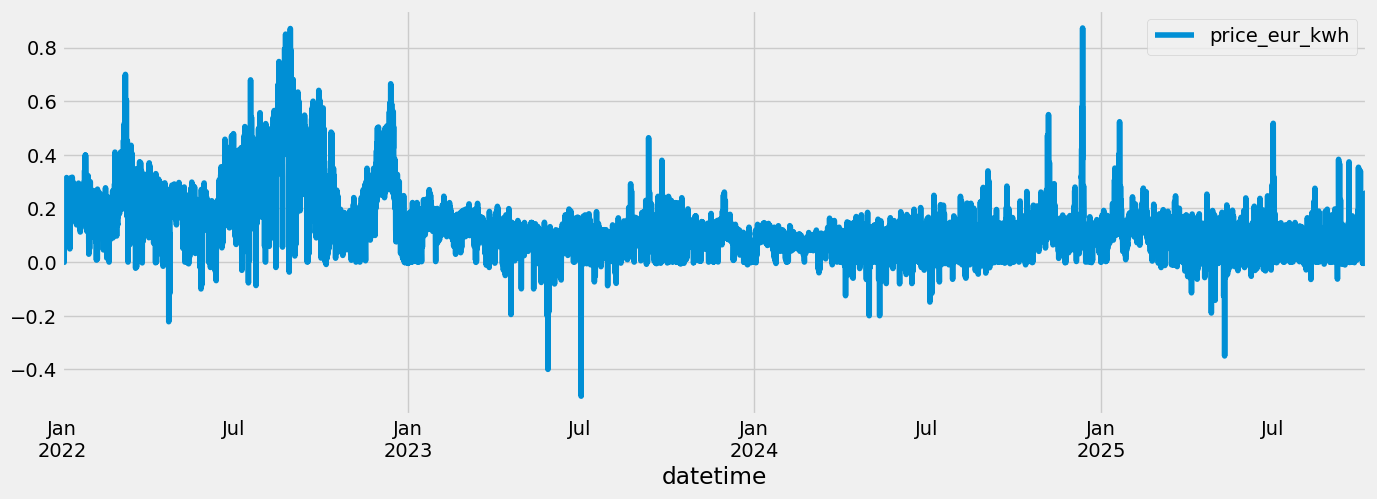

In [126]:
df.plot(figsize=(15,5), color=color_pal[0])
plt.show()

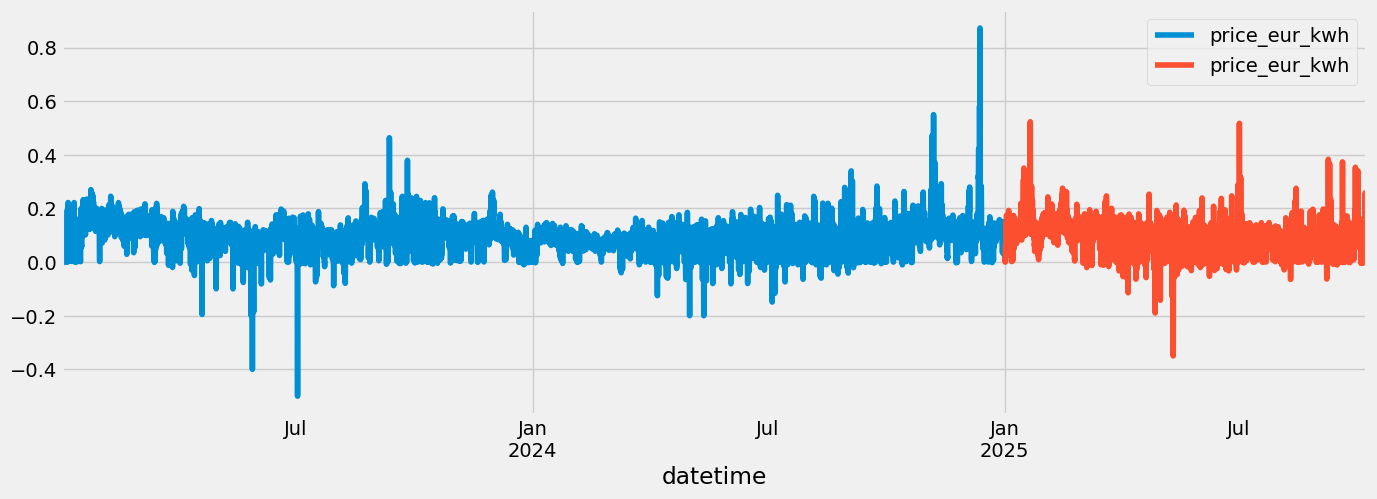

In [127]:
train = df.loc[(df.index < '01-01-2025')& (df.index > '01-01-2023')]
test = df.loc[df.index >= '01-01-2025']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.show()


# Train / Test split

In [128]:
# add cross validation

In [129]:
weather = pd.read_csv('hourly_knmi_weather')
weather = weather.set_index('datetime')
weather.index = pd.to_datetime(weather.index, utc=True)
weather.index = weather.index.tz_convert("Europe/Amsterdam")

In [130]:
df = df.join(weather, how="inner").dropna()

In [131]:
train = df.loc[(df.index < '01-01-2025')& (df.index > '01-01-2023')]
test = df.loc[df.index >= '01-01-2025']


In [132]:
import holidays
def create_features(df):
    # Feature Engineering
    df = df.copy()
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    nl_holidays = holidays.NL(years=df.index.year.unique())
    df['is_holiday'] = df.index.normalize().isin(nl_holidays).astype(int)
    df['season'] = df.index.month.map({
        12: 0, 1: 0, 2: 0,    # winter
        3: 1, 4: 1, 5: 1,     # spring
        6: 2, 7: 2, 8: 2,     # summer
        9: 3, 10: 3, 11: 3    # autumn
    })
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

    return df


Additional features?:
- gas prices

# Visualize

/var/folders/pj/f9jp23753_95j3rs1gw8cj440000gn/T/ipykernel_51829/3027757711.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns, Europe/Amsterdam] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.normalize().isin(nl_holidays).astype(int)


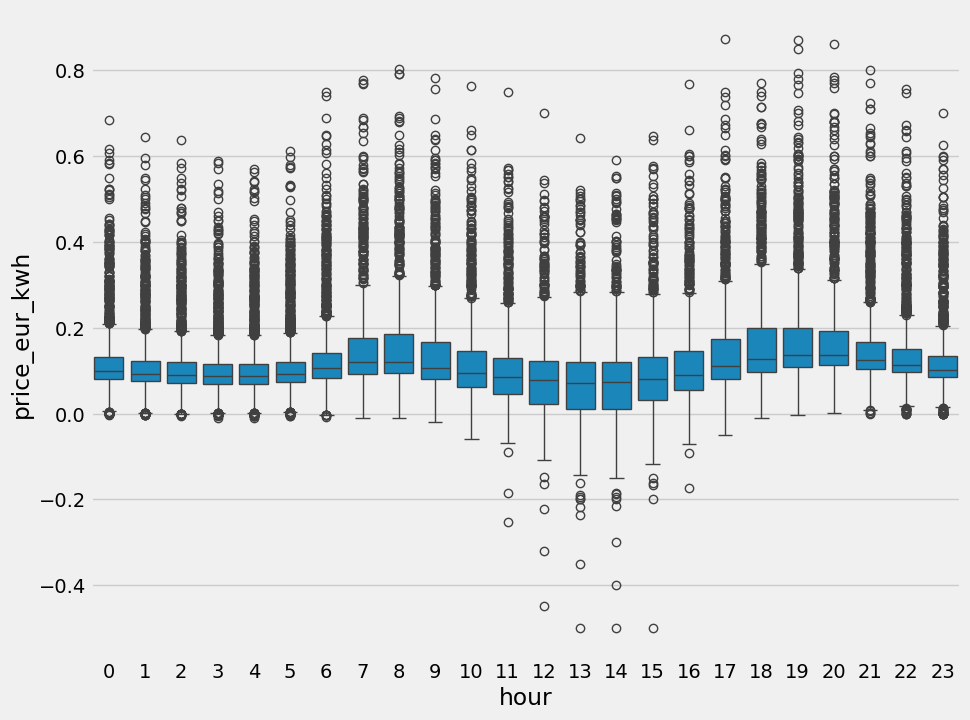

In [133]:
df = create_features(df)

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x = 'hour', y = 'price_eur_kwh')
plt.show()

# Create Model

In [134]:
train = create_features(train)
test = create_features(test)

/var/folders/pj/f9jp23753_95j3rs1gw8cj440000gn/T/ipykernel_51829/3027757711.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns, Europe/Amsterdam] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.normalize().isin(nl_holidays).astype(int)
/var/folders/pj/f9jp23753_95j3rs1gw8cj440000gn/T/ipykernel_51829/3027757711.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns, Europe/Amsterdam] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.normalize().isin(nl_holidays).astype(int)


In [135]:
FEATURES = [ 'temperature', 'precipitation', 'sun_radiation',
       'wind_speed', 'day_of_week', 'hour', 'quarter', 'month', 'is_holiday',
       'season', 'is_weekend' ]
TARGET = 'price_eur_kwh'

In [136]:
print(train)
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

                           price_eur_kwh  temperature  precipitation  \
datetime                                                               
2023-01-01 01:00:00+01:00       -0.00146         13.5            0.0   
2023-01-01 02:00:00+01:00       -0.00152         13.9            0.0   
2023-01-01 03:00:00+01:00       -0.00500         12.8            0.1   
2023-01-01 04:00:00+01:00       -0.00460         11.4            0.0   
2023-01-01 05:00:00+01:00       -0.00405         11.6            0.0   
...                                  ...          ...            ...   
2024-12-31 19:00:00+01:00        0.07056          6.4            0.0   
2024-12-31 20:00:00+01:00        0.05990          7.4            0.0   
2024-12-31 21:00:00+01:00        0.01820          7.5            0.0   
2024-12-31 22:00:00+01:00        0.00906          8.2            0.0   
2024-12-31 23:00:00+01:00        0.00052          8.3            0.0   

                           sun_radiation  wind_speed  day_of_we

In [137]:
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)
        

[0]	validation_0-rmse:0.04991	validation_1-rmse:0.05306
[100]	validation_0-rmse:0.03608	validation_1-rmse:0.03741
[200]	validation_0-rmse:0.03088	validation_1-rmse:0.03233
[300]	validation_0-rmse:0.02859	validation_1-rmse:0.03065
[400]	validation_0-rmse:0.02728	validation_1-rmse:0.02994
[500]	validation_0-rmse:0.02634	validation_1-rmse:0.02975
[600]	validation_0-rmse:0.02581	validation_1-rmse:0.02966
[700]	validation_0-rmse:0.02534	validation_1-rmse:0.02964
[735]	validation_0-rmse:0.02515	validation_1-rmse:0.02964


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importance

In [138]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
             

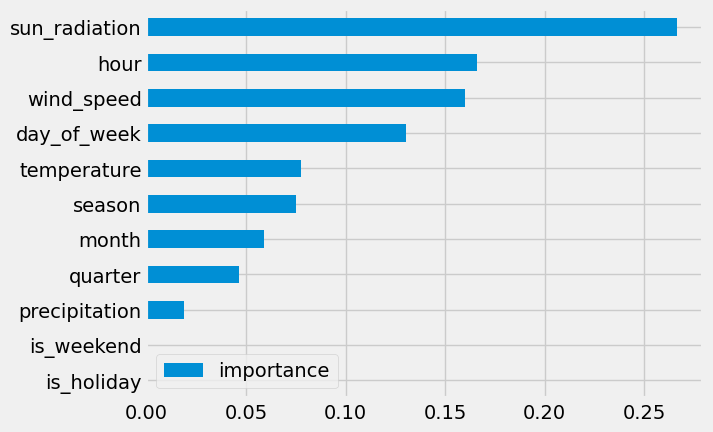

In [139]:
fi.sort_values('importance').plot(kind='barh')
plt.show()